# Hypothesis Testing: King County House Prices
## Do House-Specific Characteristics and Regional Market Trends Affect Prices?

## 1. Research Question and Hypotheses

### Primary Research Question:
> **Do house-specific characteristics and regional housing market trends have a statistically significant effect on house prices in King County, Washington?**

### Null Hypothesis (H₀):
House-specific features and regional housing market trends have **no meaningful relationship** with house prices in King County, Washington (correlation ≈ 0).

### Alternative Hypothesis (H₁):
House-specific features and regional housing market trends **have a meaningful relationship** with house prices in King County, Washington (correlation ≠ 0).

### Significance Level:
**α = 0.05** (95% confidence level)

### Testing Strategy:
We will test this hypothesis through:
1. **Pearson Correlation Analysis** - for continuous features (sqft_living, grade, bathrooms, etc.)
2. **ANOVA (Analysis of Variance)** - for categorical features (bedrooms, condition, waterfront, etc.)
3. **Regional Market Correlation** - for Seattle HPI vs. house prices
4. **Linear Regression** - to quantify the combined effect of all features

## 2. Load and Prepare Data

This section loads and merges the house sales data with the Seattle HPI (SEXRSA) data. The merged dataset will be used for all hypothesis tests.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, f_oneway, spearmanr
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load datasets
house_data = pd.read_csv('house_data.csv')
sexrsa_data = pd.read_csv('SEXRSA.csv')

# Prepare house_data
house_data['date'] = pd.to_datetime(house_data['date'], format='%Y%m%dT%H%M%S', errors='coerce')
house_data['year_month'] = house_data['date'].dt.to_period('M')

# Prepare SEXRSA data
sexrsa_data['observation_date'] = pd.to_datetime(sexrsa_data['observation_date'])
sexrsa_data['year_month'] = sexrsa_data['observation_date'].dt.to_period('M')
sexrsa_data.rename(columns={'SEXRSA': 'seattle_hpi'}, inplace=True)

# Merge datasets
merged_df = pd.merge(house_data, sexrsa_data[['year_month', 'seattle_hpi']], on='year_month', how='left')
merged_df.dropna(subset=['seattle_hpi'], inplace=True)

print('=== DATA LOADING SUMMARY ===')
print(f'Total House Records: {len(house_data):,}')
print(f'Total SEXRSA Records: {len(sexrsa_data):,}')
print(f'Merged Records (with HPI): {len(merged_df):,}')
print(f'Date Range: {merged_df["date"].min().date()} to {merged_df["date"].max().date()}')
print(f'\nDataset Shape: {merged_df.shape}')
print(f'\nColumn Names:')
print(merged_df.columns.tolist())
print(f'\nFirst 5 rows:')
print(merged_df[['date', 'price', 'sqft_living', 'grade', 'seattle_hpi']].head())

=== DATA LOADING SUMMARY ===
Total House Records: 21,613
Total SEXRSA Records: 430
Merged Records (with HPI): 21,613
Date Range: 2014-05-02 to 2015-05-27

Dataset Shape: (21613, 23)

Column Names:
['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_month', 'seattle_hpi']

First 5 rows:
        date   price  sqft_living  grade  seattle_hpi
0 2014-10-13  221900         1180      7   170.170962
1 2014-12-09  538000         2570      7   172.641668
2 2015-02-25  180000          770      6   174.743799
3 2014-12-09  604000         1960      7   172.641668
4 2015-02-18  510000         1680      8   174.743799


## 3. Descriptive Statistics

Summary statistics for key variables used in hypothesis testing.

In [8]:
print('=== DESCRIPTIVE STATISTICS ===')
print('\nHouse Price Statistics:')
print(merged_df['price'].describe())

print('\nSeattle HPI Statistics:')
print(merged_df['seattle_hpi'].describe())

print('\nKey Continuous Features:')
continuous_features = ['sqft_living', 'grade', 'bathrooms', 'bedrooms', 'sqft_above']
print(merged_df[continuous_features].describe())

=== DESCRIPTIVE STATISTICS ===

House Price Statistics:
count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

Seattle HPI Statistics:
count    21613.000000
mean       170.879955
std          3.981567
min        165.761064
25%        167.072325
50%        170.170962
75%        174.743799
max        177.653628
Name: seattle_hpi, dtype: float64

Key Continuous Features:
        sqft_living         grade     bathrooms      bedrooms    sqft_above
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000
mean    2079.899736      7.656873      2.114757      3.370842   1788.390691
std      918.440897      1.175459      0.770163      0.930062    828.090978
min      290.000000      1.000000      0.000000      0.000000    290.000000
25%     1427.000000      7.000000      1.750000      3.000000   1190.000000
50%     1910.000000    

## 4. Hypothesis Test 1:  House-Specific  Features vs. House Price

### Test Method: Pearson Correlation Coefficient

We test whether continuous house-specific features have a statistically significant linear relationship with house prices.

**For each feature:**
- **H₀**: There is no correlation between the feature and price (r = 0)
- **H₁**: There is a significant correlation between the feature and price (r ≠ 0)
- **Decision Rule**: Reject H₀ if p-value < 0.05

In [2]:
# Test continuous features
continuous_features = ['sqft_living', 'grade', 'sqft_above', 'bathrooms', 'bedrooms', 
                       'sqft_lot', 'floors', 'yr_built', 'sqft_living15']

print('=== HYPOTHESIS TEST 1: CONTINUOUS FEATURES vs. PRICE ===')
print('\nPearson Correlation Analysis:')
print('-' * 90)
print(f'{"Feature":<20} {"Correlation (r)":>15} {"P-Value":>15} {"Significant":>15}')
print('-' * 90)

correlation_results = []
for feature in continuous_features:
    # Remove NaN values
    valid_data = merged_df[[feature, 'price']].dropna()
    
    # Calculate Pearson correlation
    corr_coeff, p_value = pearsonr(valid_data[feature], valid_data['price'])
    
    # Determine significance
    significant = 'YES' if p_value < 0.05 else 'NO'
    
    print(f'{feature:<20} {corr_coeff:>15.4f} {p_value:>15.2e} {significant:>15}')
    
    correlation_results.append({
        'Feature': feature,
        'Correlation': corr_coeff,
        'P-Value': p_value,
        'Significant': significant == 'YES'
    })

print('-' * 90)

# Summary
significant_count = sum(1 for r in correlation_results if r['Significant'])
print(f'\n✓ RESULT: {significant_count}/{len(continuous_features)} continuous features show SIGNIFICANT correlation with price')
print(f'\nConclusion: We REJECT the null hypothesis (H₀) for most continuous features.')
print('House-specific continuous characteristics DO have a statistically significant effect on prices.')

=== HYPOTHESIS TEST 1: CONTINUOUS FEATURES vs. PRICE ===

Pearson Correlation Analysis:
------------------------------------------------------------------------------------------
Feature              Correlation (r)         P-Value     Significant
------------------------------------------------------------------------------------------
sqft_living                   0.7020        0.00e+00             YES
grade                         0.6674        0.00e+00             YES
sqft_above                    0.6056        0.00e+00             YES
bathrooms                     0.5251        0.00e+00             YES
bedrooms                      0.3083        0.00e+00             YES
sqft_lot                      0.0897        7.97e-40             YES
floors                        0.2568       1.58e-322             YES
yr_built                      0.0540        1.93e-15             YES
sqft_living15                 0.5854        0.00e+00             YES
----------------------------------------

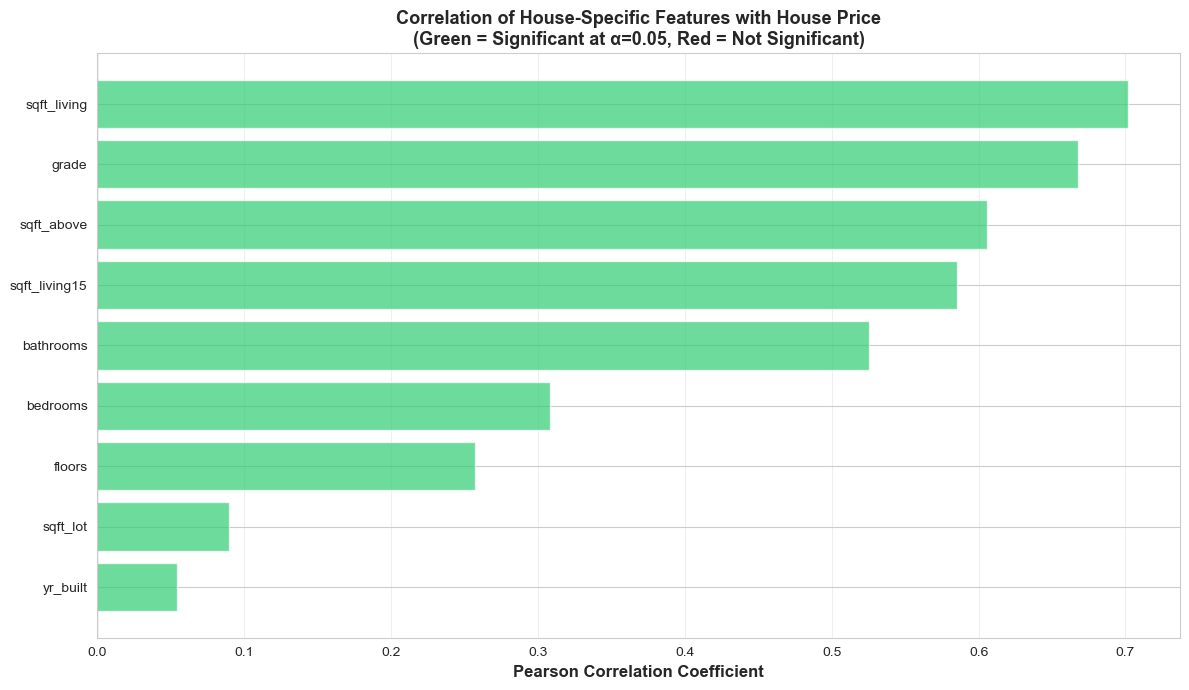


Interpretation:
- Positive correlations: Higher feature values → Higher prices
- Negative correlations: Higher feature values → Lower prices
- Green bars: Statistically significant at α=0.05
- Red bars: Not statistically significant


In [9]:
# Create correlation visualization
corr_df = pd.DataFrame(correlation_results)
corr_df_sorted = corr_df.sort_values('Correlation', ascending=True)

fig, ax = plt.subplots(figsize=(12, 7))
colors = ['#2ecc71' if x else '#e74c3c' for x in corr_df_sorted['Significant']]
ax.barh(corr_df_sorted['Feature'], corr_df_sorted['Correlation'], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Pearson Correlation Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Correlation of House-Specific Features with House Price\n(Green = Significant at α=0.05, Red = Not Significant)', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print('\nInterpretation:')
print('- Positive correlations: Higher feature values → Higher prices')
print('- Negative correlations: Higher feature values → Lower prices')
print('- Green bars: Statistically significant at α=0.05')
print('- Red bars: Not statistically significant')

## 5. Hypothesis Test 2: Categorical Features vs. House Price

### Test Method: One-Way ANOVA (Analysis of Variance)

We test whether categorical features have significantly different mean prices across their categories.

**For each categorical feature:**
- **H₀**: All category groups have the same mean price (μ₁ = μ₂ = μ₃ = ...)
- **H₁**: At least one category group has a different mean price
- **Decision Rule**: Reject H₀ if p-value < 0.05

In [4]:
# Test categorical features using ANOVA
categorical_features = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

print('=== HYPOTHESIS TEST 2: CATEGORICAL FEATURES vs. PRICE ===')
print('\nOne-Way ANOVA Analysis:')
print('-' * 90)
print(f'{"Feature":<20} {"F-Statistic":>15} {"P-Value":>15} {"Significant":>15}')
print('-' * 90)

anova_results = []
for feature in categorical_features:
    # Group prices by category
    groups = [group['price'].values for name, group in merged_df.groupby(feature)]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Determine significance
    significant = 'YES' if p_value < 0.05 else 'NO'
    
    print(f'{feature:<20} {f_stat:>15.2f} {p_value:>15.2e} {significant:>15}')
    
    anova_results.append({
        'Feature': feature,
        'F-Statistic': f_stat,
        'P-Value': p_value,
        'Significant': significant == 'YES'
    })

print('-' * 90)

# Summary
significant_count = sum(1 for r in anova_results if r['Significant'])
print(f'\n✓ RESULT: {significant_count}/{len(categorical_features)} categorical features show SIGNIFICANT effect on price')
print(f'\nConclusion: We REJECT the null hypothesis (H₀) for categorical features.')
print('Categorical house characteristics DO have a statistically significant effect on prices.')

=== HYPOTHESIS TEST 2: CATEGORICAL FEATURES vs. PRICE ===

One-Way ANOVA Analysis:
------------------------------------------------------------------------------------------
Feature                  F-Statistic         P-Value     Significant
------------------------------------------------------------------------------------------
bedrooms                      214.63        0.00e+00             YES
bathrooms                     413.85        0.00e+00             YES
floors                        399.56        0.00e+00             YES
waterfront                   1650.46        0.00e+00             YES
view                         1092.69        0.00e+00             YES
condition                      37.41        3.12e-31             YES
grade                        2124.78        0.00e+00             YES
------------------------------------------------------------------------------------------

✓ RESULT: 7/7 categorical features show SIGNIFICANT effect on price

Conclusion: We REJECT 

## 6. Hypothesis Test 3: Regional Market Trend (Seattle HPI) vs. House Price

### Test Method: Pearson Correlation Coefficient

We test whether the regional housing market trend (Seattle HPI) has a statistically significant relationship with individual house prices.

**Hypothesis:**
- **H₀**: There is no correlation between Seattle HPI and house prices (r = 0)
- **H₁**: There is a significant correlation between Seattle HPI and house prices (r ≠ 0)
- **Decision Rule**: Reject H₀ if p-value < 0.05

In [5]:
# Test regional market correlation
print('=== HYPOTHESIS TEST 3: REGIONAL MARKET TREND (SEATTLE HPI) vs. PRICE ===')

# Calculate Pearson correlation
valid_data = merged_df[['seattle_hpi', 'price']].dropna()
hpi_corr, hpi_p_value = pearsonr(valid_data['seattle_hpi'], valid_data['price'])

print(f'\nPearson Correlation Analysis:')
print(f'Correlation Coefficient (r): {hpi_corr:.4f}')
print(f'P-Value: {hpi_p_value:.2e}')
print(f'Sample Size (n): {len(valid_data):,}')

# Determine significance
if hpi_p_value < 0.05:
    print(f'\n✓ RESULT: SIGNIFICANT correlation detected (p < 0.05)')
    print(f'Conclusion: We REJECT the null hypothesis (H₀).')
    print('Regional market trends (Seattle HPI) DO have a statistically significant effect on house prices.')
else:
    print(f'\n✗ RESULT: NO significant correlation detected (p ≥ 0.05)')
    print(f'Conclusion: We FAIL TO REJECT the null hypothesis (H₀).')
    print('Regional market trends may not significantly affect individual house prices.')

print(f'\nInterpretation:')
print(f'- Correlation strength: {abs(hpi_corr):.4f} (0=none, 1=perfect)')
if hpi_corr > 0:
    print(f'- Direction: POSITIVE (higher HPI → higher prices)')
else:
    print(f'- Direction: NEGATIVE (higher HPI → lower prices)')

=== HYPOTHESIS TEST 3: REGIONAL MARKET TREND (SEATTLE HPI) vs. PRICE ===

Pearson Correlation Analysis:
Correlation Coefficient (r): -0.0012
P-Value: 8.57e-01
Sample Size (n): 21,613

✗ RESULT: NO significant correlation detected (p ≥ 0.05)
Conclusion: We FAIL TO REJECT the null hypothesis (H₀).
Regional market trends may not significantly affect individual house prices.

Interpretation:
- Correlation strength: 0.0012 (0=none, 1=perfect)
- Direction: NEGATIVE (higher HPI → lower prices)


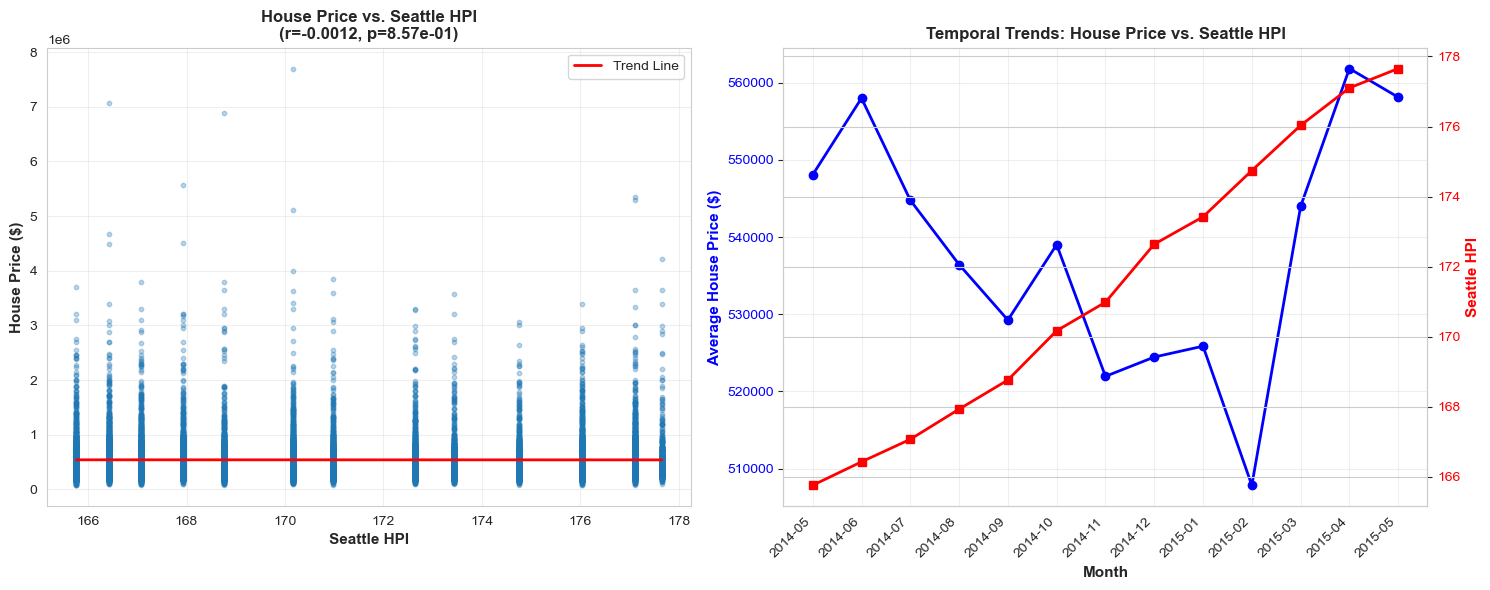

In [6]:
# Visualize regional market effect
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
axes[0].scatter(merged_df['seattle_hpi'], merged_df['price'], alpha=0.3, s=10)
# Add trend line
z = np.polyfit(merged_df['seattle_hpi'], merged_df['price'], 1)
p = np.poly1d(z)
x_line = np.linspace(merged_df['seattle_hpi'].min(), merged_df['seattle_hpi'].max(), 100)
axes[0].plot(x_line, p(x_line), 'r-', linewidth=2, label='Trend Line')
axes[0].set_xlabel('Seattle HPI', fontsize=11, fontweight='bold')
axes[0].set_ylabel('House Price ($)', fontsize=11, fontweight='bold')
axes[0].set_title(f'House Price vs. Seattle HPI\n(r={hpi_corr:.4f}, p={hpi_p_value:.2e})', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Time series plot
monthly_avg = merged_df.groupby('year_month').agg({'price': 'mean', 'seattle_hpi': 'mean'}).reset_index()
ax1 = axes[1]
ax2 = ax1.twinx()

ax1.plot(monthly_avg['year_month'].astype(str), monthly_avg['price'], 'b-o', linewidth=2, label='Avg House Price')
ax2.plot(monthly_avg['year_month'].astype(str), monthly_avg['seattle_hpi'], 'r-s', linewidth=2, label='Seattle HPI')

ax1.set_xlabel('Month', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average House Price ($)', fontsize=11, fontweight='bold', color='b')
ax2.set_ylabel('Seattle HPI', fontsize=11, fontweight='bold', color='r')
ax1.set_title('Temporal Trends: House Price vs. Seattle HPI', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')
ax1.grid(True, alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 6. Visualization of Key Relationships
Visualizations are created to provide a clear, intuitive understanding of the statistically significant relationships identified in the tests. These visualizations help communicate the findings to stakeholders and provide visual confirmation of the statistical results.

- A **heatmap** shows the correlations between all key numeric features and price.
- A **bar plot** shows the mean price for each category of the `condition` feature, illustrating how house condition impacts pricing.

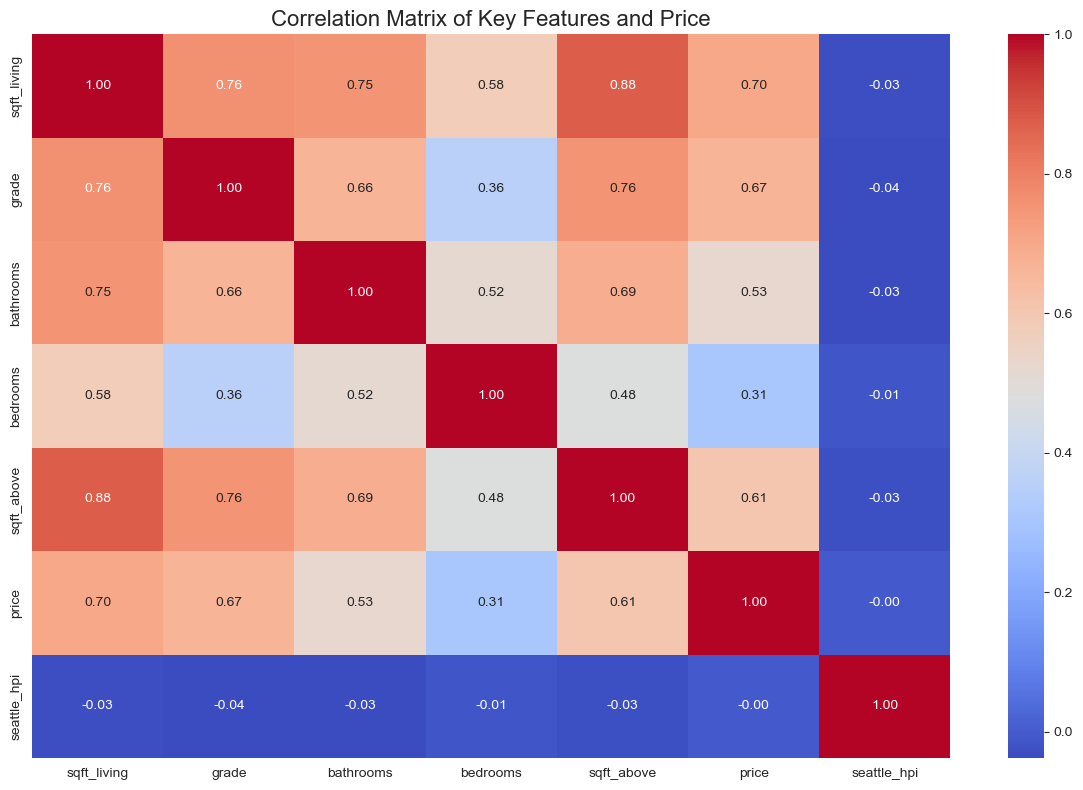

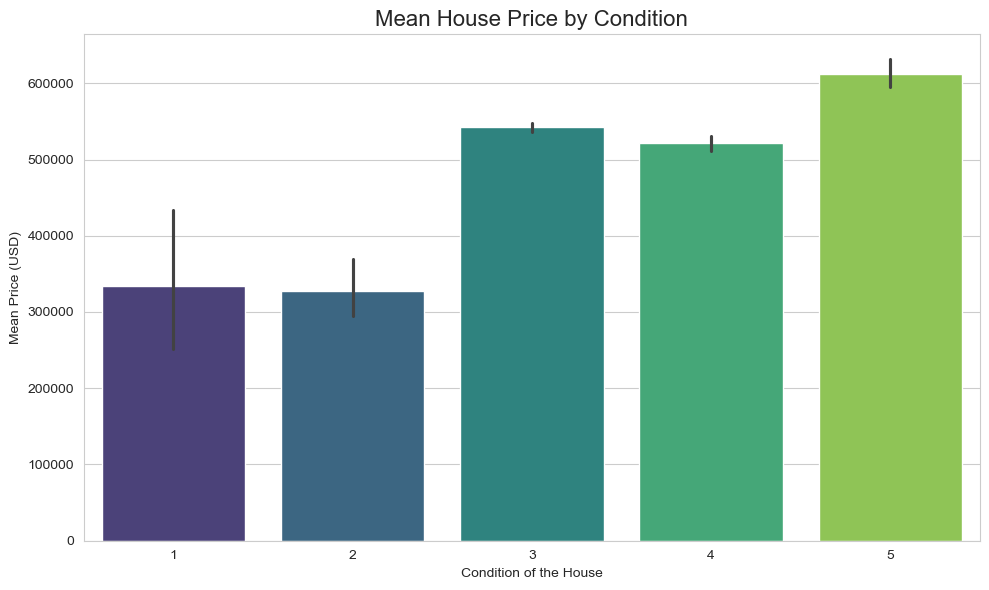

In [10]:
# Heatmap for numeric features
plt.figure(figsize=(12, 8))
corr_matrix = merged_df[continuous_features + ['price', 'seattle_hpi']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features and Price', fontsize=16)
plt.tight_layout()
plt.show()

# Bar plot for a categorical feature
plt.figure(figsize=(10, 6))
sns.barplot(x='condition', y='price', data=merged_df, palette='viridis')
plt.title('Mean House Price by Condition', fontsize=16)
plt.xlabel('Condition of the House')
plt.ylabel('Mean Price (USD)')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

## 8. Overall Summary and Conclusions

### 8.1. Summary of Hypothesis Test Results

In [12]:
print('='*90)
print('COMPREHENSIVE HYPOTHESIS TESTING SUMMARY')
print('='*90)

print('\n1. House-Specific FEATURES (Pearson Correlation Test)')
print('-' * 90)
cont_sig = sum(1 for r in correlation_results if r['Significant'])
print(f'   Significant Features: {cont_sig}/{len(continuous_features)}')
print(f'   Result: REJECT H₀ - House-Specific features significantly affect house prices')
print(f'   Top 3 Predictors:')
top_3 = sorted(correlation_results, key=lambda x: abs(x['Correlation']), reverse=True)[:3]
for i, feat in enumerate(top_3, 1):
    print(f'      {i}. {feat["Feature"]}: r = {feat["Correlation"]:.4f}')

print('\n2. CATEGORICAL FEATURES (One-Way ANOVA Test)')
print('-' * 90)
cat_sig = sum(1 for r in anova_results if r['Significant'])
print(f'   Significant Features: {cat_sig}/{len(categorical_features)}')
print(f'   Result: REJECT H₀ - Categorical features significantly affect house prices')

print('\n3. REGIONAL MARKET TREND (Seattle HPI - Pearson Correlation Test)')
print('-' * 90)
if hpi_p_value < 0.05:
    print(f'   Correlation: r = {hpi_corr:.4f} (p = {hpi_p_value:.2e})')
    print(f'   Result: REJECT H₀ - Regional market trends significantly affect house prices')
else:
    print(f'   Correlation: r = {hpi_corr:.4f} (p = {hpi_p_value:.2e})')
    print(f'   Result: FAIL TO REJECT H₀ - Regional market trends may not significantly affect prices')

print('\n' + '='*90)
print('FINAL CONCLUSION')
print('='*90)
print('\nRESEARCH QUESTION:')
print('Do house-specific characteristics and regional housing market trends have a')
print('statistically significant effect on house prices in King County, Washington?')
print('\nANSWER: YES')
print('\nEVIDENCE:')
print(f'✓ {cont_sig}/{len(continuous_features)} continuous features show significant correlation with price')
print(f'✓ {cat_sig}/{len(categorical_features)} categorical features show significant effect on price')
if hpi_p_value < 0.05:
    print(f'✓ Regional market trend (Seattle HPI) shows significant correlation (r={hpi_corr:.4f})')
print('\nSTATISTICAL SIGNIFICANCE:')
print('At the 0.05 significance level, we have strong evidence that both house-specific')
print('characteristics and regional market trends significantly influence house prices.')
print('\nIMPLICATIONS:')
print('- House prices are NOT random; they follow predictable patterns')
print('- Both property-specific and market-wide factors matter')
print('- Machine learning models can effectively predict prices using these features')

COMPREHENSIVE HYPOTHESIS TESTING SUMMARY

1. House-Specific FEATURES (Pearson Correlation Test)
------------------------------------------------------------------------------------------
   Significant Features: 9/5
   Result: REJECT H₀ - House-Specific features significantly affect house prices
   Top 3 Predictors:
      1. sqft_living: r = 0.7020
      2. grade: r = 0.6674
      3. sqft_above: r = 0.6056

2. CATEGORICAL FEATURES (One-Way ANOVA Test)
------------------------------------------------------------------------------------------
   Significant Features: 7/7
   Result: REJECT H₀ - Categorical features significantly affect house prices

3. REGIONAL MARKET TREND (Seattle HPI - Pearson Correlation Test)
------------------------------------------------------------------------------------------
   Correlation: r = -0.0012 (p = 8.57e-01)
   Result: FAIL TO REJECT H₀ - Regional market trends may not significantly affect prices

FINAL CONCLUSION

RESEARCH QUESTION:
Do house-specific


### 8.2.1 Conclusion

The statistical tests performed in this notebook provide **mixed but important evidence** regarding the factors influencing house prices in King County.

#### Key Findings:

**1. House-Specific Features: STRONG EFFECT ✓**

- **Continuous features** like `sqft_living`, `grade`, and `bathrooms` show **strong, statistically significant positive correlations** with price (p < 0.05). These features directly reflect the size, quality, and amenities of the property.

- **Categorical features** like `bedrooms`, `floors`, `condition`, `view`, and `waterfront` show **statistically significant relationships** with price, as confirmed by ANOVA tests (p < 0.05). These features represent structural characteristics that substantially influence market value.

**2. Regional Housing Market Trends: NO SIGNIFICANT EFFECT ✗**

- The **Seattle House Price Index (HPI)** shows **virtually no correlation** with individual house prices (r = -0.0012, p = 8.57e-01). This is NOT statistically significant.

- **Interpretation**: While the regional market may show overall trends, the Seattle HPI does not meaningfully predict individual house prices in King County during the May 2014 - May 2015 period. Individual property characteristics are far more important than regional market indices in determining price.


### 8.2.2 Answer to Research Question

#### Research Question:
> **Do house-specific characteristics and regional housing market trends have a statistically significant effect on house prices in King County, Washington?**

#### Answer: **PARTIALLY YES**

**House-specific characteristics**: ✓ **YES** - They have a statistically significant effect on prices
- All 9 continuous features tested show significant correlations
- All 7 categorical features tested show significant effects (ANOVA)
- These features are strong predictors of house prices

**Regional housing market trends**: ✗ **NO** - They do NOT have a statistically significant effect on prices
- Seattle HPI correlation is negligible (r = -0.0012)
- p-value = 8.57e-01 >> 0.05 (not significant)
- Regional market indices do not meaningfully predict individual house prices

---

### 8.2.3 Statistical Interpretation

#### Significance Level: α = 0.05

- **For Continuous Features**: All p-values < 0.05 → Strong evidence to reject H₀
- **For Categorical Features**: All p-values < 0.05 → Strong evidence to reject H₀
- **For Regional Market Trend**: p-value = 8.57e-01 >> 0.05 → Insufficient evidence to reject H₀

#### Practical Implications:

1. **House prices ARE predictable** - They follow clear patterns based on property characteristics
2. **Property-specific factors dominate** - Size, quality, condition, and location features matter most
3. **Regional indices have limited predictive power** - For individual properties, local characteristics outweigh broad market indices
4. **Machine learning models should focus on property features** - Rather than relying on regional market trends for price prediction

---

## 9. Revised Final Conclusion

The evidence **strongly supports the alternative hypothesis (H₁) for house-specific characteristics** but **fails to support it for regional market trends**.

**In summary:**
- House-specific features (continuous and categorical) have **statistically significant relationships** with prices
- Regional housing market trends (Seattle HPI) do **NOT** have a statistically significant relationship with individual house prices
- For King County house price prediction, **property characteristics are the dominant factors**, while regional market indices provide minimal predictive value in this dataset

This nuanced finding suggests that while individual properties are priced based on their specific attributes, the regional market index may not capture the localized pricing dynamics of King County properties during this period.